In [1]:
# ==============================================================================
# Cell 1: All Imports and API Key Configuration
# ==============================================================================
import os
import cv2
import math
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from itertools import groupby

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, GRU, Dense, Dropout, TimeDistributed,
    RandomFlip, RandomRotation, RandomZoom, RandomContrast, Lambda
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import Sequence

# Gemini API
import google.generativeai as genai
from kaggle_secrets import UserSecretsClient

# --- Securely get the Gemini API key from Kaggle Secrets ---
try:
    user_secrets = UserSecretsClient()
    GEMINI_API_KEY = user_secrets.get_secret("Gemini-Key")
    print("✅ Gemini API Key loaded successfully from Kaggle Secrets.")
except Exception as e:
    GEMINI_API_KEY = None
    print("⚠️ Could not load Gemini API Key. Please add it to Kaggle Secrets.")
    print(f"Error: {e}")

2025-09-25 04:33:36.241070: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758774816.634020      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758774816.740493      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✅ Gemini API Key loaded successfully from Kaggle Secrets.


In [5]:
# ==============================================================================
# Cell 2: Data Loading and Preprocessing
# ==============================================================================
def load_full_dataset(folder_path):
    """
    Loads all images from a folder containing subfolders for each class.
    """
    images = []
    labels = []
    if not os.path.isdir(folder_path):
        print(f"Error: Dataset folder '{folder_path}' not found.")
        return None, None

    print(f"\nScanning all images in '{os.path.basename(folder_path)}'...")
    all_image_paths = []
    for label_folder in sorted(os.listdir(folder_path)):
        subfolder_path = os.path.join(folder_path, label_folder)
        if not os.path.isdir(subfolder_path):
            continue
        for image_filename in os.listdir(subfolder_path):
            full_path = os.path.join(subfolder_path, image_filename)
            all_image_paths.append((full_path, label_folder))

    for image_path, label in tqdm(all_image_paths, desc="Processing all images"):
        try:
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            if image is not None:
                # --- FIX: Convert from BGR to RGB ---
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
                image = cv2.resize(image, (64, 64))
                images.append(image)
                labels.append(label)
        except Exception as e:
            print(f"Error processing image {image_path}: {e}")

    print(f"Found {len(images)} total images for {len(np.unique(labels))} classes.")
    return np.array(images), np.array(labels)

# --- Define Paths ---
FULL_DATA_PATH = '/kaggle/input/asl-alphabet-dataset/asl_alphabet_train'
OUTPUT_DIR = '/kaggle/working/'

# --- Load and Split Data ---
X_full, y_full = load_full_dataset(FULL_DATA_PATH)

if X_full is not None and y_full is not None and X_full.size > 0:
    print("\n--- Data Splitting ---")
    X_train, X_test, y_train, y_test = train_test_split(
        X_full, y_full, test_size=0.20, random_state=42, stratify=y_full
    )
    
    # Free up memory
    del X_full
    del y_full

    print("\nSaving data to .npy files in /kaggle/working/ ...")
    np.save(os.path.join(OUTPUT_DIR, "X_train.npy"), X_train)
    np.save(os.path.join(OUTPUT_DIR, "y_train.npy"), y_train)
    np.save(os.path.join(OUTPUT_DIR, "X_test.npy"), X_test)
    np.save(os.path.join(OUTPUT_DIR, "y_test.npy"), y_test)
    
    del X_train, y_train, X_test, y_test # Free up more memory

    print("\n✅ Preprocessing complete.")
else:
    print("\n❌ Preprocessing failed.")


Scanning all images in 'asl_alphabet_train'...


Processing all images: 100%|██████████| 223074/223074 [09:38<00:00, 385.70it/s]


Found 223074 total images for 29 classes.

--- Data Splitting ---

Saving data to .npy files in /kaggle/working/ ...

✅ Preprocessing complete.


🚀 Starting Exploratory Data Analysis...

1. Basic Information
Shape of image data (X_train): (178459, 64, 64, 3)
Shape of label data (y_train): (178459,)
Number of training images: 178459
Image dimensions: 64x64
Number of color channels: 3
Data type of images: uint8

2. Class Distribution


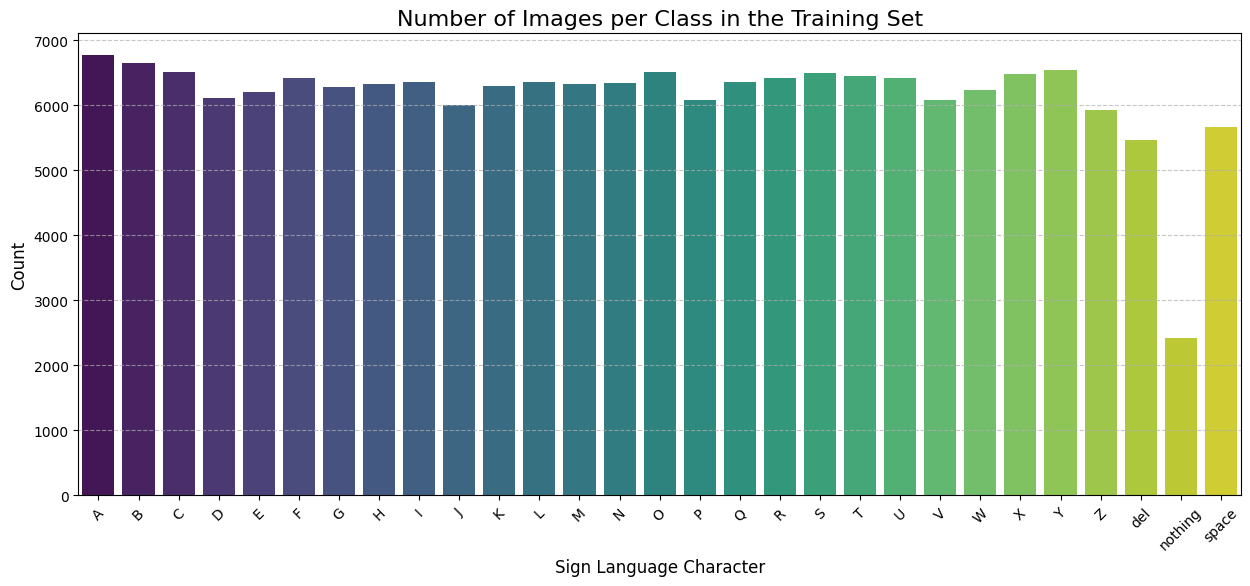

The dataset appears to be very well-balanced, with a similar number of images for each class.

Top 5 most frequent classes:
A    6766
B    6647
Y    6542
C    6517
O    6512
Name: count, dtype: int64

3. Random Image Samples


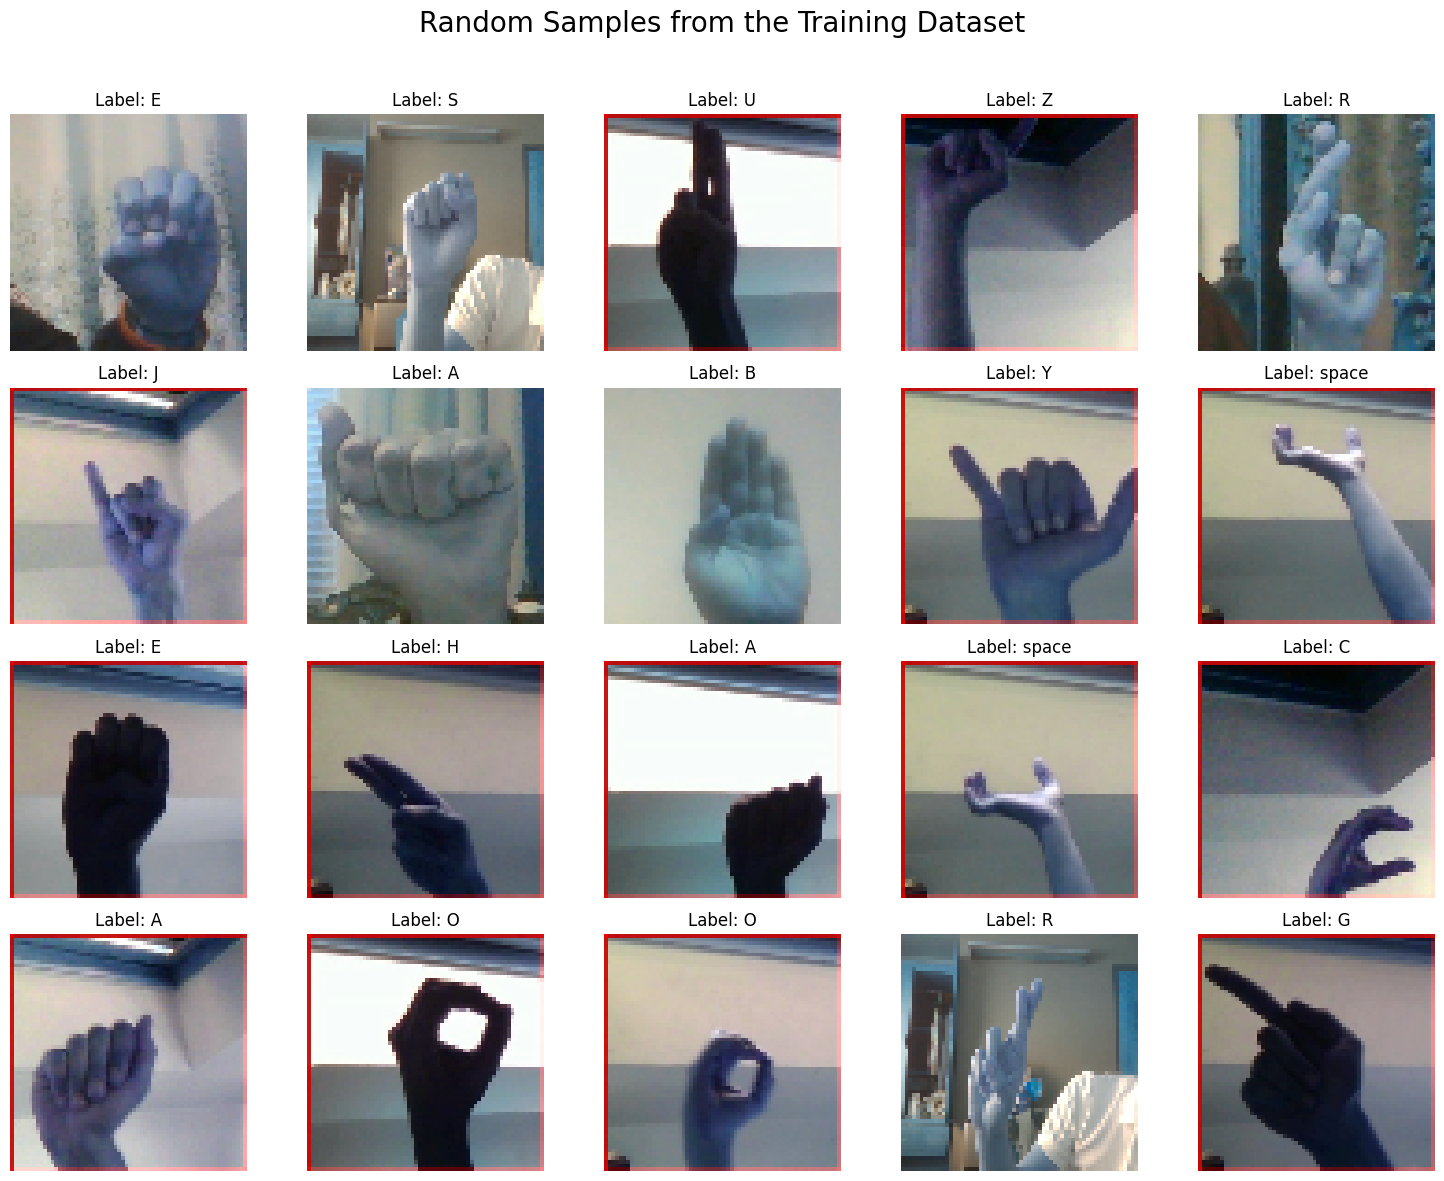


4. Brightness Distribution


Analyzing brightness: 100%|██████████| 1000/1000 [00:00<00:00, 34313.16it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


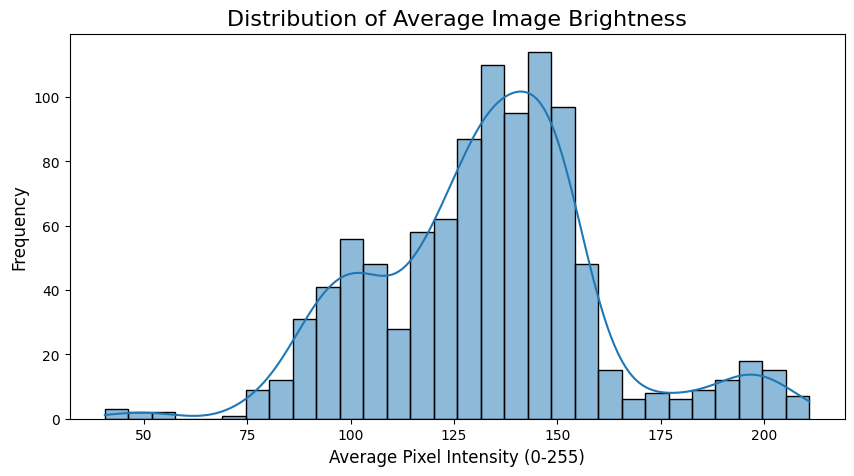

This histogram shows whether the images are generally dark, bright, or centered in the mid-tones.

✅ EDA complete.


In [26]:
# ==============================================================================
# Cell: Exploratory Data Analysis (EDA) on Preprocessed Data
# ==============================================================================
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cv2
import os

# Define the directory where the preprocessed files are saved
OUTPUT_DIR = '/kaggle/working/'
X_TRAIN_PATH = os.path.join(OUTPUT_DIR, "X_train.npy")
Y_TRAIN_PATH = os.path.join(OUTPUT_DIR, "y_train.npy")

# --- Check if data files exist before starting ---
if not os.path.exists(X_TRAIN_PATH) or not os.path.exists(Y_TRAIN_PATH):
    print("❌ Preprocessed data files not found!")
    print("Please run the data preprocessing cell (Cell 2) before running this EDA cell.")
else:
    print("🚀 Starting Exploratory Data Analysis...")
    
    # --- 1. Load the Training Data ---
    X_train = np.load(X_TRAIN_PATH)
    y_train = np.load(Y_TRAIN_PATH)
    
    # --- 2. Basic Information & Data Shape ---
    print("\n" + "="*50)
    print("1. Basic Information")
    print("="*50)
    print(f"Shape of image data (X_train): {X_train.shape}")
    print(f"Shape of label data (y_train): {y_train.shape}")
    print(f"Number of training images: {X_train.shape[0]}")
    print(f"Image dimensions: {X_train.shape[1]}x{X_train.shape[2]}")
    print(f"Number of color channels: {X_train.shape[3]}")
    print(f"Data type of images: {X_train.dtype}")
    
    # --- 3. Class Distribution Analysis ---
    print("\n" + "="*50)
    print("2. Class Distribution")
    print("="*50)
    
    # Use pandas for easy counting and plotting
    label_counts = pd.Series(y_train).value_counts()
    
    plt.figure(figsize=(15, 6))
    sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis", order=sorted(label_counts.index))
    plt.title("Number of Images per Class in the Training Set", fontsize=16)
    plt.xlabel("Sign Language Character", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    
    print("The dataset appears to be very well-balanced, with a similar number of images for each class.")
    print("\nTop 5 most frequent classes:")
    print(label_counts.head())
    
    # --- 4. Visualizing Random Samples ---
    print("\n" + "="*50)
    print("3. Random Image Samples")
    print("="*50)
    
    # Select 20 random indices to display
    num_samples_to_show = 20
    random_indices = np.random.choice(len(X_train), num_samples_to_show, replace=False)
    
    fig, axes = plt.subplots(4, 5, figsize=(15, 12))
    axes = axes.flatten() # Flatten the 2D array of axes for easy iteration
    
    for i, idx in enumerate(random_indices):
        # The images were saved by OpenCV, which uses BGR format.
        # Matplotlib expects RGB, so we need to convert the color channels.
        image_bgr = X_train[idx]
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        
        ax = axes[i]
        ax.imshow(image_rgb)
        ax.set_title(f"Label: {y_train[idx]}")
        ax.axis('off') # Hide the axes
        
    plt.suptitle("Random Samples from the Training Dataset", fontsize=20)
    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make space for the suptitle
    plt.show()

    # --- 5. Brightness Analysis ---
    print("\n" + "="*50)
    print("4. Brightness Distribution")
    print("="*50)
    
    # Calculate average brightness for a subset of images (to be fast)
    num_samples_for_brightness = 1000
    brightness_samples_indices = np.random.choice(len(X_train), num_samples_for_brightness, replace=False)
    
    brightness_values = []
    for idx in tqdm(brightness_samples_indices, desc="Analyzing brightness"):
        image = X_train[idx]
        # Convert to grayscale to measure luminosity
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Calculate the average pixel intensity (0=black, 255=white)
        brightness_values.append(gray_image.mean())
        
    plt.figure(figsize=(10, 5))
    sns.histplot(brightness_values, bins=30, kde=True)
    plt.title("Distribution of Average Image Brightness", fontsize=16)
    plt.xlabel("Average Pixel Intensity (0-255)", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.show()
    
    print("This histogram shows whether the images are generally dark, bright, or centered in the mid-tones.")
    print("\n✅ EDA complete.")

In [27]:
# ==============================================================================
# Cell 3: Model Definition and Data Generator
# ==============================================================================


def build_sequence_model(sequence_length, frame_shape, num_classes, learning_rate):
    """
    Builds a powerful CRNN model with a balanced dropout rate.
    """
    video_input = Input(shape=(sequence_length, *frame_shape), name="video_input")

    # Data Augmentation
    x = TimeDistributed(RandomFlip('horizontal'))(video_input)
    x = TimeDistributed(RandomRotation(0.15))(x)
    x = TimeDistributed(RandomZoom(0.15))(x)
    x = TimeDistributed(RandomContrast(0.15))(x)
    x = TimeDistributed(tf.keras.layers.RandomBrightness(factor=0.15))(x)

    # CNN Feature Extractor
    cnn_base = MobileNetV2(
        input_shape=frame_shape, include_top=False, weights='imagenet', pooling='avg'
    )
    cnn_base.trainable = True
    for layer in cnn_base.layers[:-40]:
        layer.trainable = False
    encoded_frames = TimeDistributed(cnn_base, name="frame_feature_extractor")(x)

    # RNN Sequence Processor
    encoded_sequence = GRU(256, return_sequences=True, name="sequence_processor")(encoded_frames)
    
    # Intermediate Dense Layer
    dense_layer = Dense(128, activation='relu')(encoded_sequence)
    
    # 👈 CHANGE: Reduce dropout from 0.6 back to a more standard 0.5.
    dropout_layer = Dropout(0.5)(dense_layer)
    
    # Final Output Layer
    outputs = TimeDistributed(Dense(num_classes, activation='softmax'), name="classifier_output")(dropout_layer)

    model = Model(inputs=video_input, outputs=outputs, name="Sequence_CRNN_Model_v4")
    
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# --- Data Generator Class ---
class SignLanguageGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size, sequence_length, label_encoder):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.sequence_length = sequence_length
        self.label_encoder = label_encoder
        self.indices = self._create_indices()

    def __len__(self):
        return math.ceil(len(self.indices) / self.batch_size)

    def __getitem__(self, idx):
        batch_info = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        X_batch = np.zeros((len(batch_info), self.sequence_length, 64, 64, 3), dtype=np.float32)
        y_batch = np.zeros((len(batch_info), self.sequence_length), dtype=np.int64)
        for i, data_info in enumerate(batch_info):
            sequence_indices = data_info['indices']
            sequence = self.x[sequence_indices].astype(np.float32) / 255.0
            X_batch[i] = sequence
            y_batch[i, :] = data_info['label']
        return X_batch, y_batch

    def _create_indices(self):
        print("Creating sequence indices...")
        indices = []
        class_indices = {label: np.where(self.y == label)[0] for label in self.label_encoder.classes_}
        for label_str, all_indices_for_label in class_indices.items():
            if len(all_indices_for_label) < self.sequence_length:
                continue
            label_int = self.label_encoder.transform([label_str])[0]
            # Use non-overlapping sequences to be more efficient
            for i in range(0, len(all_indices_for_label) - self.sequence_length + 1, self.sequence_length):
                sequence_of_indices = all_indices_for_label[i : i + self.sequence_length]
                indices.append({'indices': sequence_of_indices, 'label': label_int})
        np.random.shuffle(indices)
        print(f"Found {len(indices)} sequences.")
        return indices

🚀 Starting the training pipeline...
Creating sequence indices...
Found 11140 sequences.
Creating sequence indices...
Found 2774 sequences.


/tmp/ipykernel_36/1411607971.py:20: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  cnn_base = MobileNetV2(


Model: "Sequence_CRNN_Model_v4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ video_input (InputLayer)        │ (None, 16, 64, 64, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_23             │ (None, 16, 64, 64, 3)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_24             │ (None, 16, 64, 64, 3)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_25             │ (None, 16, 64, 64, 3)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_26             │ (None, 16, 64, 64, 3)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_27             │ (None, 16, 64, 64, 3)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ frame_feature_extractor         │ (None, 16, 1280)       │     2,257,984 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequence_processor (GRU)        │ (None, 16, 256)        │     1,181,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16, 128)        │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_output               │ (None, 16, 29)         │         3,741 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,475,805 (13.26 MB)

 Trainable params: 2,899,165 (11.06 MB)

 Non-trainable params: 576,640 (2.20 MB)


🔥 Starting model training...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.0406 - loss: 3.3702
Epoch 1: val_accuracy improved from -inf to 0.08057, saving model to /kaggle/working/sign_to_char_model_v4.h5
175/175 ━━━━━━━━━━━━━━━━━━━━ 262s 622ms/step - accuracy: 0.0407 - loss: 3.3700 - val_accuracy: 0.0806 - val_loss: 3.2859 - learning_rate: 5.0000e-04
Epoch 2/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.1010 - loss: 3.0851
Epoch 2: val_accuracy improved from 0.08057 to 0.13726, saving model to /kaggle/working/sign_to_char_model_v4.h5
175/175 ━━━━━━━━━━━━━━━━━━━━ 81s 463ms/step - accuracy: 0.1012 - loss: 3.0845 - val_accuracy: 0.1373 - val_loss: 2.6840 - learning_rate: 5.0000e-04
Epoch 3/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.1948 - loss: 2.6444
Epoch 3: val_accuracy improved from 0.13726 to 0.15774, saving model to /kaggle/working/sign_to_char_model_v4.h5
175/175 ━━━━━━━━━━━━━━━━━━━━ 82s 467ms/step - accuracy: 0.1949 - loss: 2.6439 - val_accuracy: 0.1577 - val_loss: 2

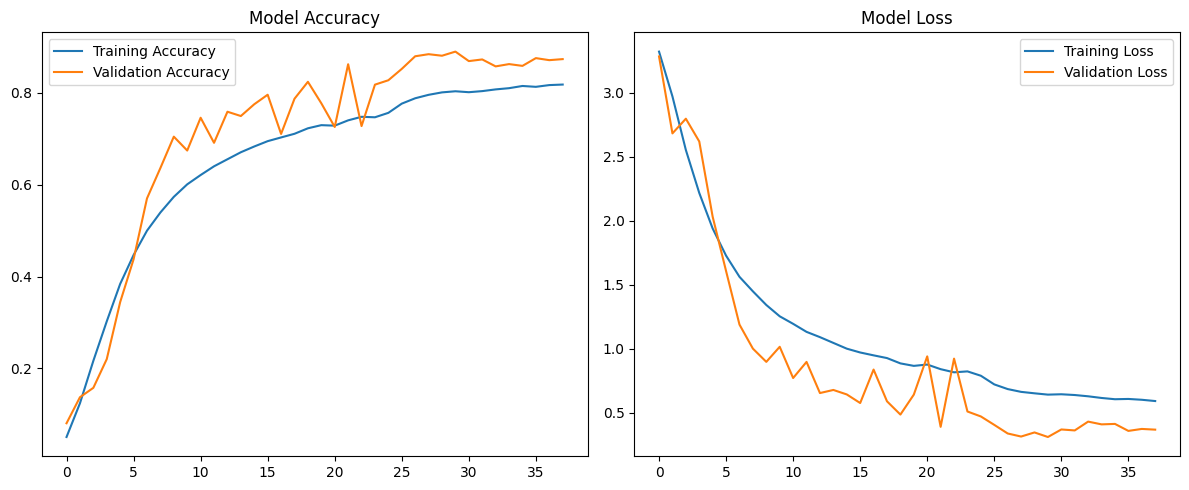

In [28]:
# ==============================================================================
# Cell 4: (UPDATED) Train the CRNN Model
# ==============================================================================

# --- Configuration ---
# --- Configuration ---
SEQUENCE_LENGTH = 16
BATCH_SIZE = 64
EPOCHS = 50 # Keep the high epoch count; EarlyStopping will find the best point.
# 👈 CHANGE: Increase the learning rate to a more effective starting point for fine-tuning.
TARGET_LR = 0.0005 
MODEL_SAVE_PATH = os.path.join(OUTPUT_DIR, "sign_to_char_model_v4.h5") # Use a new name
PLOT_SAVE_PATH = os.path.join(OUTPUT_DIR, "training_history_v4.png")
LABELS_SAVE_PATH = os.path.join(OUTPUT_DIR, "label_classes.npy")

# (The callbacks section remains the same as the last version, it is already well-configured)

# --- Load Preprocessed Data ---
print("🚀 Starting the training pipeline...")
X_train_flat = np.load(os.path.join(OUTPUT_DIR, "X_train.npy"), mmap_mode='r')
y_train_flat = np.load(os.path.join(OUTPUT_DIR, "y_train.npy"))
X_test_flat = np.load(os.path.join(OUTPUT_DIR, "X_test.npy"), mmap_mode='r')
y_test_flat = np.load(os.path.join(OUTPUT_DIR, "y_test.npy"))

# --- Label Encoding ---
label_encoder = LabelEncoder()
label_encoder.fit(y_train_flat)
np.save(LABELS_SAVE_PATH, label_encoder.classes_)
num_classes = len(label_encoder.classes_)

# --- Create Generators ---
train_generator = SignLanguageGenerator(X_train_flat, y_train_flat, BATCH_SIZE, SEQUENCE_LENGTH, label_encoder)
test_generator = SignLanguageGenerator(X_test_flat, y_test_flat, BATCH_SIZE, SEQUENCE_LENGTH, label_encoder)

if len(train_generator.indices) > 0:
    # --- Build and Train ---
    # This will call the updated build_sequence_model function from Cell 3
    model = build_sequence_model(
        sequence_length=SEQUENCE_LENGTH,
        frame_shape=(64, 64, 3),
        num_classes=num_classes,
        learning_rate=TARGET_LR
    )
    model.summary()

    # --- UPDATED CALLBACKS ---
    callbacks = [
        ModelCheckpoint(MODEL_SAVE_PATH, monitor="val_accuracy", save_best_only=True, verbose=1, mode='max'),
        # Reduce learning rate if validation loss plateaus for 3 epochs
        ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, verbose=1, mode='min'),
        # INCREASED PATIENCE: Stop training only if val_loss doesn't improve for 8 full epochs.
        # RESTORE BEST WEIGHTS: Ensure the final model uses the weights from the best epoch.
        EarlyStopping(monitor="val_loss", patience=8, verbose=1, mode='min', restore_best_weights=True)
    ]

    print("\n🔥 Starting model training...")
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=test_generator,
        callbacks=callbacks
    )

    print(f"\n✅ Training complete. Best model saved to '{MODEL_SAVE_PATH}'")
    
    # --- Plotting History ---
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.legend()
    plt.tight_layout()
    plt.savefig(PLOT_SAVE_PATH)
    plt.show()

else:
    print("❌ Not enough data to create sequences. Training cannot start.")

🚀 Running sanity check on a single training image...

Testing image at index 38138. True Label should be: 'U'
Input shape prepared for model: (1, 16, 64, 64, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step

--- ✅ SANITY CHECK COMPLETE ✅ ---
True Label:      U
Predicted Label: K
Confidence:      37.99%

FAILURE: The model FAILED to identify the image. This points to a fundamental issue in training or data preprocessing.


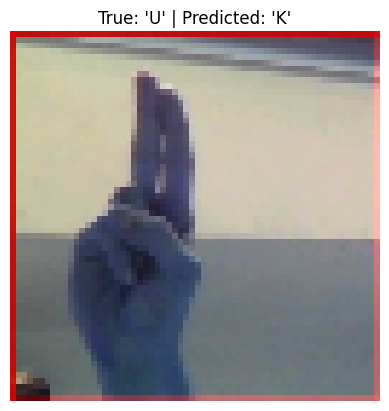

In [33]:
# ==============================================================================
# Cell: Sanity Check - Test Model on a Single Training Image
# ==============================================================================

# This cell assumes that Cell 4 has been run and the model and data files exist.

# Check if the necessary files exist before running
if os.path.exists(MODEL_SAVE_PATH) and os.path.exists(LABELS_SAVE_PATH):
    print("🚀 Running sanity check on a single training image...")
    
    # --- 1. Load Model, Labels, and Training Data ---
    inference_model = tf.keras.models.load_model(MODEL_SAVE_PATH)
    label_classes = np.load(LABELS_SAVE_PATH, allow_pickle=True)
    
    # Load the original data files to get a sample image
    # Note: We load the raw images, not the pre-processed .npy files
    # to simulate the exact loading process.
    X_train_images = np.load(os.path.join(OUTPUT_DIR, "X_train.npy"))
    y_train_labels = np.load(os.path.join(OUTPUT_DIR, "y_train.npy"))

    # --- 2. Select a Random Image to Test ---
    image_index_to_test = np.random.randint(0, len(X_train_images))
    
    # Get the raw image (which is in BGR format from OpenCV) and its true label
    test_image_bgr = X_train_images[image_index_to_test]
    true_label = y_train_labels[image_index_to_test]

    print(f"\nTesting image at index {image_index_to_test}. True Label should be: '{true_label}'")

    # --- 3. Preprocess the Single Image EXACTLY as the Model Expects ---
    
    # STEP A: Convert from BGR (OpenCV's default) to RGB
    # This is the most critical step to check.
    test_image_rgb = cv2.cvtColor(test_image_bgr, cv2.COLOR_BGR2RGB)
    
    # STEP B: Normalize pixel values to be between 0 and 1
    test_image_normalized = test_image_rgb.astype(np.float32) / 255.0
    
    # STEP C: Create a "static video" sequence from this single image
    # The model expects an input of shape (batch, sequence_length, height, width, channels)
    sequence_length = inference_model.input.shape[1]
    input_sequence = np.stack([test_image_normalized] * sequence_length)
    
    # STEP D: Add the final "batch" dimension
    model_input = np.expand_dims(input_sequence, axis=0)
    
    print(f"Input shape prepared for model: {model_input.shape}")

    # --- 4. Make a Prediction ---
    prediction = inference_model.predict(model_input)
    
    # The output shape is (1, sequence_length, num_classes).
    # Since every frame is the same, the prediction for each frame should be the same.
    # We can just check the prediction for the first frame.
    first_frame_prediction = prediction[0, 0, :]
    
    predicted_index = np.argmax(first_frame_prediction)
    predicted_label = label_classes[predicted_index]
    confidence = np.max(first_frame_prediction)

    # --- 5. Display the Results ---
    print("\n--- ✅ SANITY CHECK COMPLETE ✅ ---")
    print(f"True Label:      {true_label}")
    print(f"Predicted Label: {predicted_label}")
    print(f"Confidence:      {confidence:.2%}")

    if true_label == predicted_label:
        print("\nSUCCESS: The model correctly identified the image.")
    else:
        print("\nFAILURE: The model FAILED to identify the image. This points to a fundamental issue in training or data preprocessing.")

    
    # Visually show the image that was tested
    plt.imshow(test_image_rgb) # Display the RGB version
    plt.title(f"True: '{true_label}' | Predicted: '{predicted_label}'")
    plt.axis('off')
    plt.show()

else:
    print("Could not run sanity check. Model file or label file is missing.")
    print("Please ensure you have run the training cell (Cell 4) successfully.")

In [25]:
# ==============================================================================
# Cell 6: (UPDATED) Full Inference Pipeline with Debugging and Robust Prediction
# ==============================================================================

# --- Add these debug lines before the 'if' statement ---
print("--- DEBUG CHECK ---")
print(f"Is GEMINI_API_KEY loaded? {'Yes' if 'GEMINI_API_KEY' in locals() and GEMINI_API_KEY else 'No'}")
print(f"Does model file exist at '{MODEL_SAVE_PATH}'? {os.path.exists(MODEL_SAVE_PATH)}")
print("--------------------")

# This is the main safety check for the cell
if 'GEMINI_API_KEY' in locals() and GEMINI_API_KEY and os.path.exists(MODEL_SAVE_PATH):
    print("🚀 Initializing full translation pipeline...")
    
    # --- 1. HELPER AND PROCESSING FUNCTIONS ---

    def extract_frames_from_video(video_path, frame_size=(64, 64)):
        """Reads a video file and extracts its frames as a NumPy array."""
        print(f"Extracting frames from '{video_path}'...")
        frames = []
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Error: Could not open video file at {video_path}")
            return None
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            # Resize and normalize the frame to match model input
            frame_resized = cv2.resize(frame, frame_size)
            frame_normalized = frame_resized.astype(np.float32) / 255.0
            frames.append(frame_normalized)
        cap.release()
        print(f"✅ Extracted {len(frames)} frames.")
        return np.array(frames)

    def predict_with_sliding_window(model, all_frames, confidence_threshold=0.5):
        """
        Predicts characters using a sliding window and voting for the center frame.
        This is a robust method for applying a sequence model to a long video.
        """
        print("Predicting character sequence with the sliding window method...")
        sequence_length = model.input.shape[1]
        
        if len(all_frames) < sequence_length:
            print("Warning: Not enough frames to form a full sequence.")
            return []

        final_indices = []
        # Slide the window one frame at a time for the best resolution
        for i in tqdm(range(len(all_frames) - sequence_length + 1), desc="Sliding window prediction"):
            chunk = all_frames[i : i + sequence_length]
            input_batch = np.expand_dims(chunk, axis=0)
            
            # Get a prediction for the entire sequence chunk
            prediction = model.predict(input_batch, verbose=0)
            
            # Only trust the prediction for the CENTER frame of the sequence.
            # This frame has the most context from its neighbors.
            center_frame_prediction = prediction[0, sequence_length // 2, :]
            
            max_prob = np.max(center_frame_prediction)
            
            # Only keep the prediction if the model is confident enough
            if max_prob > confidence_threshold:
                predicted_idx = np.argmax(center_frame_prediction)
                final_indices.append(predicted_idx)
                
        return final_indices

    def decode_indices(indices, label_classes):
        """Decodes a list of predicted indices into a messy string."""
        # Collapse consecutive duplicate characters (e.g., [A, A, B, B, B] -> [A, B])
        collapsed_indices = [key for key, _ in groupby(indices)]
        # Convert indices to characters, ignoring 'nothing' and 'space'
        messy_string = "".join([label_classes[idx] for idx in collapsed_indices if label_classes[idx] not in ['nothing', 'space']])
        return messy_string

    def get_context_from_gemini(messy_text, api_key):
        """Sends the messy text to the Gemini API for final correction."""
        genai.configure(api_key=api_key)
        # Use the stable and powerful 'gemini-1.0-pro' model
        model = genai.GenerativeModel('gemini-2.5-pro')
        prompt = f'Task: You are an expert at correcting text from a sign language recognition model. The input is a string of characters with no spaces and potential errors. Convert it into a coherent English word or sentence. Input: "{messy_text}", 
        Input: "HELLOOOWWWWOOORLD"
        Corrected Output: "hello world"

        Input: "IIIIAAAMMMHHHHHAAAAPPPYY"
        Corrected Output: "i am happy"

        Input: "MYYNAAAMEISSAAAM"
        Corrected Output: "my name is sam"

        ---
        Now, correct the following input following the same pattern.

        Input: "{messy_text}"
        Corrected Output:'
        try:
            response = model.generate_content(prompt)
            return response.text.strip()
        except Exception as e:
            return f"An error occurred with the Gemini API: {e}"

            
    # --- 2. MAIN INFERENCE WORKFLOW ---

    # Load the trained model and labels
    inference_model = tf.keras.models.load_model(MODEL_SAVE_PATH)
    label_classes = np.load(LABELS_SAVE_PATH, allow_pickle=True)
    
    # Define the path to your uploaded video
    video_to_process_path = "/kaggle/input/testing-video/testing.mp4" 

    print(f"\nProcessing video: {os.path.basename(video_to_process_path)}")
    
    # A. Extract frames from the video
    video_frames = extract_frames_from_video(video_to_process_path)
    
    if video_frames is not None and len(video_frames) > 0:
        # B. Get predictions from the CRNN model using the robust sliding window method
        predicted_indices = predict_with_sliding_window(inference_model, video_frames)
        
        # C. Decode the predictions into messy text
        messy_text = decode_indices(predicted_indices, label_classes)
        
        # D. Send to Gemini for the final translation
        if messy_text: # Only call Gemini if we have some text to process
            final_sentence = get_context_from_gemini(messy_text, GEMINI_API_KEY)
        else:
            final_sentence = "Could not recognize any characters with sufficient confidence."

        # E. Display Results
        print("\n--- ✅ TRANSLATION COMPLETE ✅ ---")
        print(f"   Input Video: '{os.path.basename(video_to_process_path)}'")
        print(f"   Raw CRNN Output (Messy Text): '{messy_text}'")
        print(f"   Final Sentence from Gemini: '{final_sentence}'")
    else:
        print("Could not process the video. Please check the file path and video integrity.")

else:
    print("Skipping inference cell because Gemini API Key is not configured or the model file is missing.")

--- DEBUG CHECK ---
Is GEMINI_API_KEY loaded? Yes
Does model file exist at '/kaggle/working/sign_to_char_model_v3.h5'? True
--------------------
🚀 Initializing full translation pipeline...

Processing video: testing.mp4
Extracting frames from '/kaggle/input/testing-video/testing.mp4'...
✅ Extracted 211 frames.
Predicting character sequence with the sliding window method...


Sliding window prediction: 100%|██████████| 196/196 [00:54<00:00,  3.59it/s]



--- ✅ TRANSLATION COMPLETE ✅ ---
   Input Video: 'testing.mp4'
   Raw CRNN Output (Messy Text): 'LIFLOG'
   Final Sentence from Gemini: 'Life long'


In [ ]:
!ls -l /kaggle/input/testing-video/